# Lab 13: GANs, Part I

## Example 1: Generate a mixture of Gaussians

Suppose we have an unknwon distribution $p_\text{data}(\mathbf{x})$ that is in fact a mixture of three Gaussian distributions:


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Sample from p_data(x):

def sample_pdata(m):
    means_gt = [ [1,10], [10,1], [10,10] ]
    sigmas_gt = [ np.matrix([[1, 0],[0, 1]]), np.matrix([[4,0],[0,1]]),
                  np.matrix([[1,0],[0,4]]) ]
    phi_gt = [ 0.2, 0.2, 0.6 ]
    n = len(means_gt[0])
    k = len(phi_gt)
    Z = [0]*m
    X = np.zeros((m,n))
    # Generate m samples from multinomial distribution using phi_gt
    z_vectors = np.random.multinomial(1, phi_gt, size=m)  # Result: binary matrix of size (m x k)
    for i in range(m):
        # Convert one-hot representation z_vectors[i,:] to an index
        Z[i] = np.where(z_vectors[i,:] == 1)[0][0]
        # Grab ground truth mean mu_{z^i}
        mu = means_gt[Z[i]]                
        # Grab ground truth covariance Sigma_{z^i}
        sigma = sigmas_gt[Z[i]]
        # Sample a 2D point from mu, sigma
        X[i,:] = np.random.multivariate_normal(mu,sigma,1)
    return X


Let's generate a sample from this ground truth distribution:

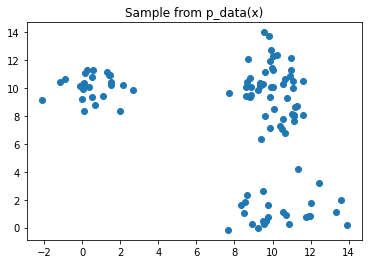

In [2]:
X = sample_pdata(100)

plt.scatter(X[:,0],X[:,1])
plt.title('Sample from p_data(x)')
plt.show()

Next we need a function to sample from the noise distribution:

In [3]:
def sample_noise(m, n):
    return np.random.multivariate_normal([0,0],[[1, 0],[0, 1]], m)   

Let's get a sample from the noise distribution:

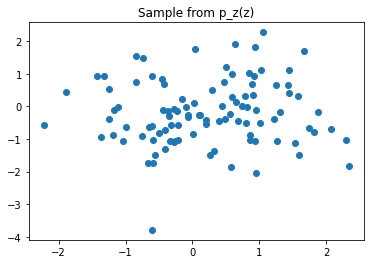

In [4]:
Z = sample_noise(100, 2)

plt.scatter(Z[:,0],Z[:,1])
plt.title('Sample from p_z(z)')
plt.show()

Next, let's define a discriminator and generator:

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GeneratorNet(nn.Module):
    def __init__(self):
        super(GeneratorNet, self).__init__()
        # First fully connected layer
        self.fc1 = nn.Linear(2, 4)
        # Second fully connected layer
        self.fc2 = nn.Linear(4, 4)
        self.output = nn.Linear(4, 2)
    
    def forward(self, x):
        # Pass data through fc1
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        output = self.output(x)
        return output
    
class DiscriminatorNet(nn.Module):
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        # First fully connected layer
        self.fc1 = nn.Linear(2, 4)
        # Second fully connected layer
        self.fc2 = nn.Linear(4, 4)
        self.output = nn.Linear(4, 1)
    
    def forward(self, x):
        # Pass data through fc1
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        output = self.output(x)
        output = F.sigmoid(output)
        return output
        

Let's create instances of the generator and discriminator and test that G() can process a sample from the noise distribution and that D() can process a sample from the data distribution or the output of the generator:

In [6]:
# Instantiate the generator and discriminator

G = GeneratorNet()
D = DiscriminatorNet()

# xhat = G(noise sample)

z = torch.tensor(sample_noise(10, 2)).float()
print('Generator input:', z)
xhat = G(z)
print('Generator output:', xhat)

# decisions on fake data = D(G(noise sample))

decisions_fake = D(xhat)
print('Discriminator output for generated data:', decisions_fake)

# decisions on real data = D(data sample)

x = torch.tensor(sample_pdata(10)).float()
decisions_real = D(x)
print('Discriminator output for real data:', decisions_real)

Generator input: tensor([[-0.3307, -1.2438],
        [-0.0748,  0.3203],
        [-1.0791, -1.1283],
        [ 1.0944,  0.5997],
        [ 0.6280,  0.8366],
        [ 0.8802, -1.4307],
        [ 0.2523,  1.5147],
        [ 1.1702, -2.5039],
        [ 0.9569, -0.5147],
        [ 0.5719, -0.6656]])
Generator output: tensor([[-0.4653,  0.4805],
        [-0.4300,  0.6272],
        [-0.4685,  0.4832],
        [-0.4266,  0.6827],
        [-0.4254,  0.7094],
        [-0.4602,  0.4762],
        [-0.4180,  0.8074],
        [-0.4726,  0.4867],
        [-0.4384,  0.5350],
        [-0.4452,  0.5210]], grad_fn=<AddmmBackward>)
Discriminator output for generated data: tensor([[0.5156],
        [0.5157],
        [0.5156],
        [0.5158],
        [0.5158],
        [0.5156],
        [0.5159],
        [0.5156],
        [0.5157],
        [0.5156]], grad_fn=<SigmoidBackward>)
Discriminator output for real data: tensor([[0.7775],
        [0.7263],
        [0.8027],
        [0.6423],
        [0.5308],
   

Let's write some code to train these models using the algorithm from Goodfellow et al. (2014):

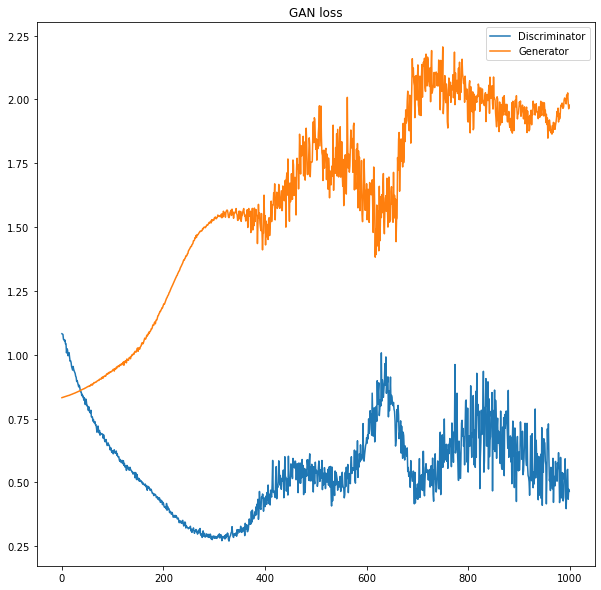

In [11]:
from IPython.display import clear_output
from torch import optim
%matplotlib inline

num_iters = 1000
num_minibatches_discriminator = 1
minibatch_size = 100
n = 2

G = GeneratorNet()
D = DiscriminatorNet()

D_optimizer = optim.Adam(D.parameters(), lr=0.001)
G_optimizer = optim.Adam(G.parameters(), lr=0.001)
loss = nn.BCELoss()

# for number of training iterations

d_losses = []
g_losses = []

def do_plot(d_losses, g_losses):
    plt.figure(figsize=(10,10))
    clear_output(wait=True)
    plt.plot(d_losses, label='Discriminator')
    plt.plot(g_losses, label='Generator')
    plt.title('GAN loss')
    plt.legend()
    plt.show()

G.train()
D.train()

for iter in range(num_iters):
    
    # Train discriminator for num_minibatches_discriminator minibatches

    d_loss = 0
    for discriminator_iter in range(num_minibatches_discriminator):
        D.zero_grad()
        D_optimizer.zero_grad()
        x = torch.tensor(sample_pdata(minibatch_size)).float()
        z = torch.tensor(sample_noise(minibatch_size, n)).float()
        xhat = G(z)
        decisions_real = D(x)
        real_targets = torch.ones(minibatch_size, 1)
        error_real = loss(decisions_real, real_targets)
        error_real.backward()
        decisions_fake = D(xhat)
        fake_targets = torch.zeros(minibatch_size, 1)
        error_fake = loss(decisions_fake, fake_targets)
        error_fake.backward()
        D_optimizer.step()
        d_loss += error_real + error_fake

    # Train generator on one minibatch
    
    G.zero_grad()
    D.zero_grad()
    G_optimizer.zero_grad()
    z = torch.tensor(sample_noise(minibatch_size, n)).float()
    xhat = G(z)
    decisions_fake = D(xhat)
    fake_targets = torch.ones(minibatch_size, 1)
    g_loss = loss(decisions_fake, fake_targets)
    g_loss.backward()
    G_optimizer.step()

    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())
    
    do_plot(d_losses, g_losses)


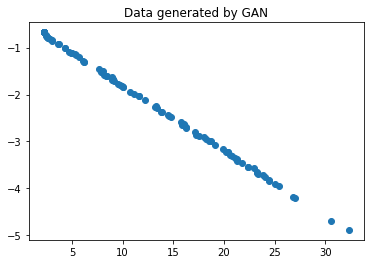

In [12]:
G.eval()
z = torch.tensor(sample_noise(100, 2)).float()
xhat = G(z).detach().numpy()

plt.scatter(xhat[:,0],xhat[:,1])
plt.title('Data generated by GAN')
plt.show()

### In-class exercise

As the results are not yet convincing, perform some further experiments with bigger noise vectors, larger networks, and different hyperparameters to improve the results. In your report, describe your experiments and demonstrate the results.